In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import xarray as xr
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")

In [2]:
polarization_bidi = xr.open_dataset("polarization_bidi_dataset_conn_sweep.nc")
polarization_bidi

<xarray.Dataset>
Dimensions:                         (sweep_idd: 10001, fiber_num: 7,
                                     connector_num: 6,
                                     connector_return_loss: 5, port: 4,
                                     heaters: 4, axis: 4, chip: 2,
                                     simulation_mode: 1)
Coordinates:
  * sweep_idd                       (sweep_idd) int32 0 1 2 ... 9998 9999 10000
  * fiber_num                       (fiber_num) object 'fiber_1' ... 'fiber_7'
  * connector_num                   (connector_num) object 'connector_1' ... ...
  * connector_return_loss           (connector_return_loss) int32 -30 ... -50
  * port                            (port) object 'reverse_top' ... 'forward_...
  * heaters                         (heaters) object 'PA-1:XPS1' ... 'MZI-1:X...
  * axis                            (axis) object 'rx' 'ry' 'rz' 'delta'
  * chip                            (chip) object 'chip-1' 'chip-2'
  * simulation_mode                 (simulation_mode) object 'monte_carlo'
Data variables:
    fiber_rotation                  (simulation_mode, sweep_idd, connector_return_loss, fiber_num, axis) float64 ...
    connector_loss                  (simulation_mode, sweep_idd, connector_return_loss, connector_num) float64 ...
    input_state                     (simulation_mode, sweep_idd, connector_return_loss, port) float64 ...
    input_state_reverse             (simulation_mode, sweep_idd, connector_return_loss, port) float64 ...
    output_state_forward_intensity  (simulation_mode, sweep_idd, connector_return_loss, port) float64 ...
    output_state_reverse_intensity  (simulation_mode, sweep_idd, connector_return_loss, port) float64 ...
    heater_params                   (simulation_mode, sweep_idd, connector_return_loss, heaters) float64 ...
    io_loss                         (simulation_mode, sweep_idd, connector_return_loss, chip) float64 ...
    dc1                             (simulation_mode, sweep_idd, connector_return_loss) float64 ...
    dc2                             (simulation_mode, sweep_idd, connector_return_loss) float64 ...
    dc_sigma                        (simulation_mode, sweep_idd, connector_return_loss) float64 ...
Attributes:
    description:  Dataset for polarization controller bidi model
    author:       Ashwyn S
    created:      2023-11-29

In [3]:
polarization_bidi['output_state_forward_intensity'].sel(simulation_mode = 'monte_carlo')

<xarray.DataArray 'output_state_forward_intensity' (sweep_idd: 10001,
                                                    connector_return_loss: 5,
                                                    port: 4)>
[200020 values with dtype=float64]
Coordinates:
  * sweep_idd              (sweep_idd) int32 0 1 2 3 4 ... 9997 9998 9999 10000
  * connector_return_loss  (connector_return_loss) int32 -30 -35 -40 -45 -50
  * port                   (port) object 'reverse_top' ... 'forward_bottom'
    simulation_mode        <U11 'monte_carlo'

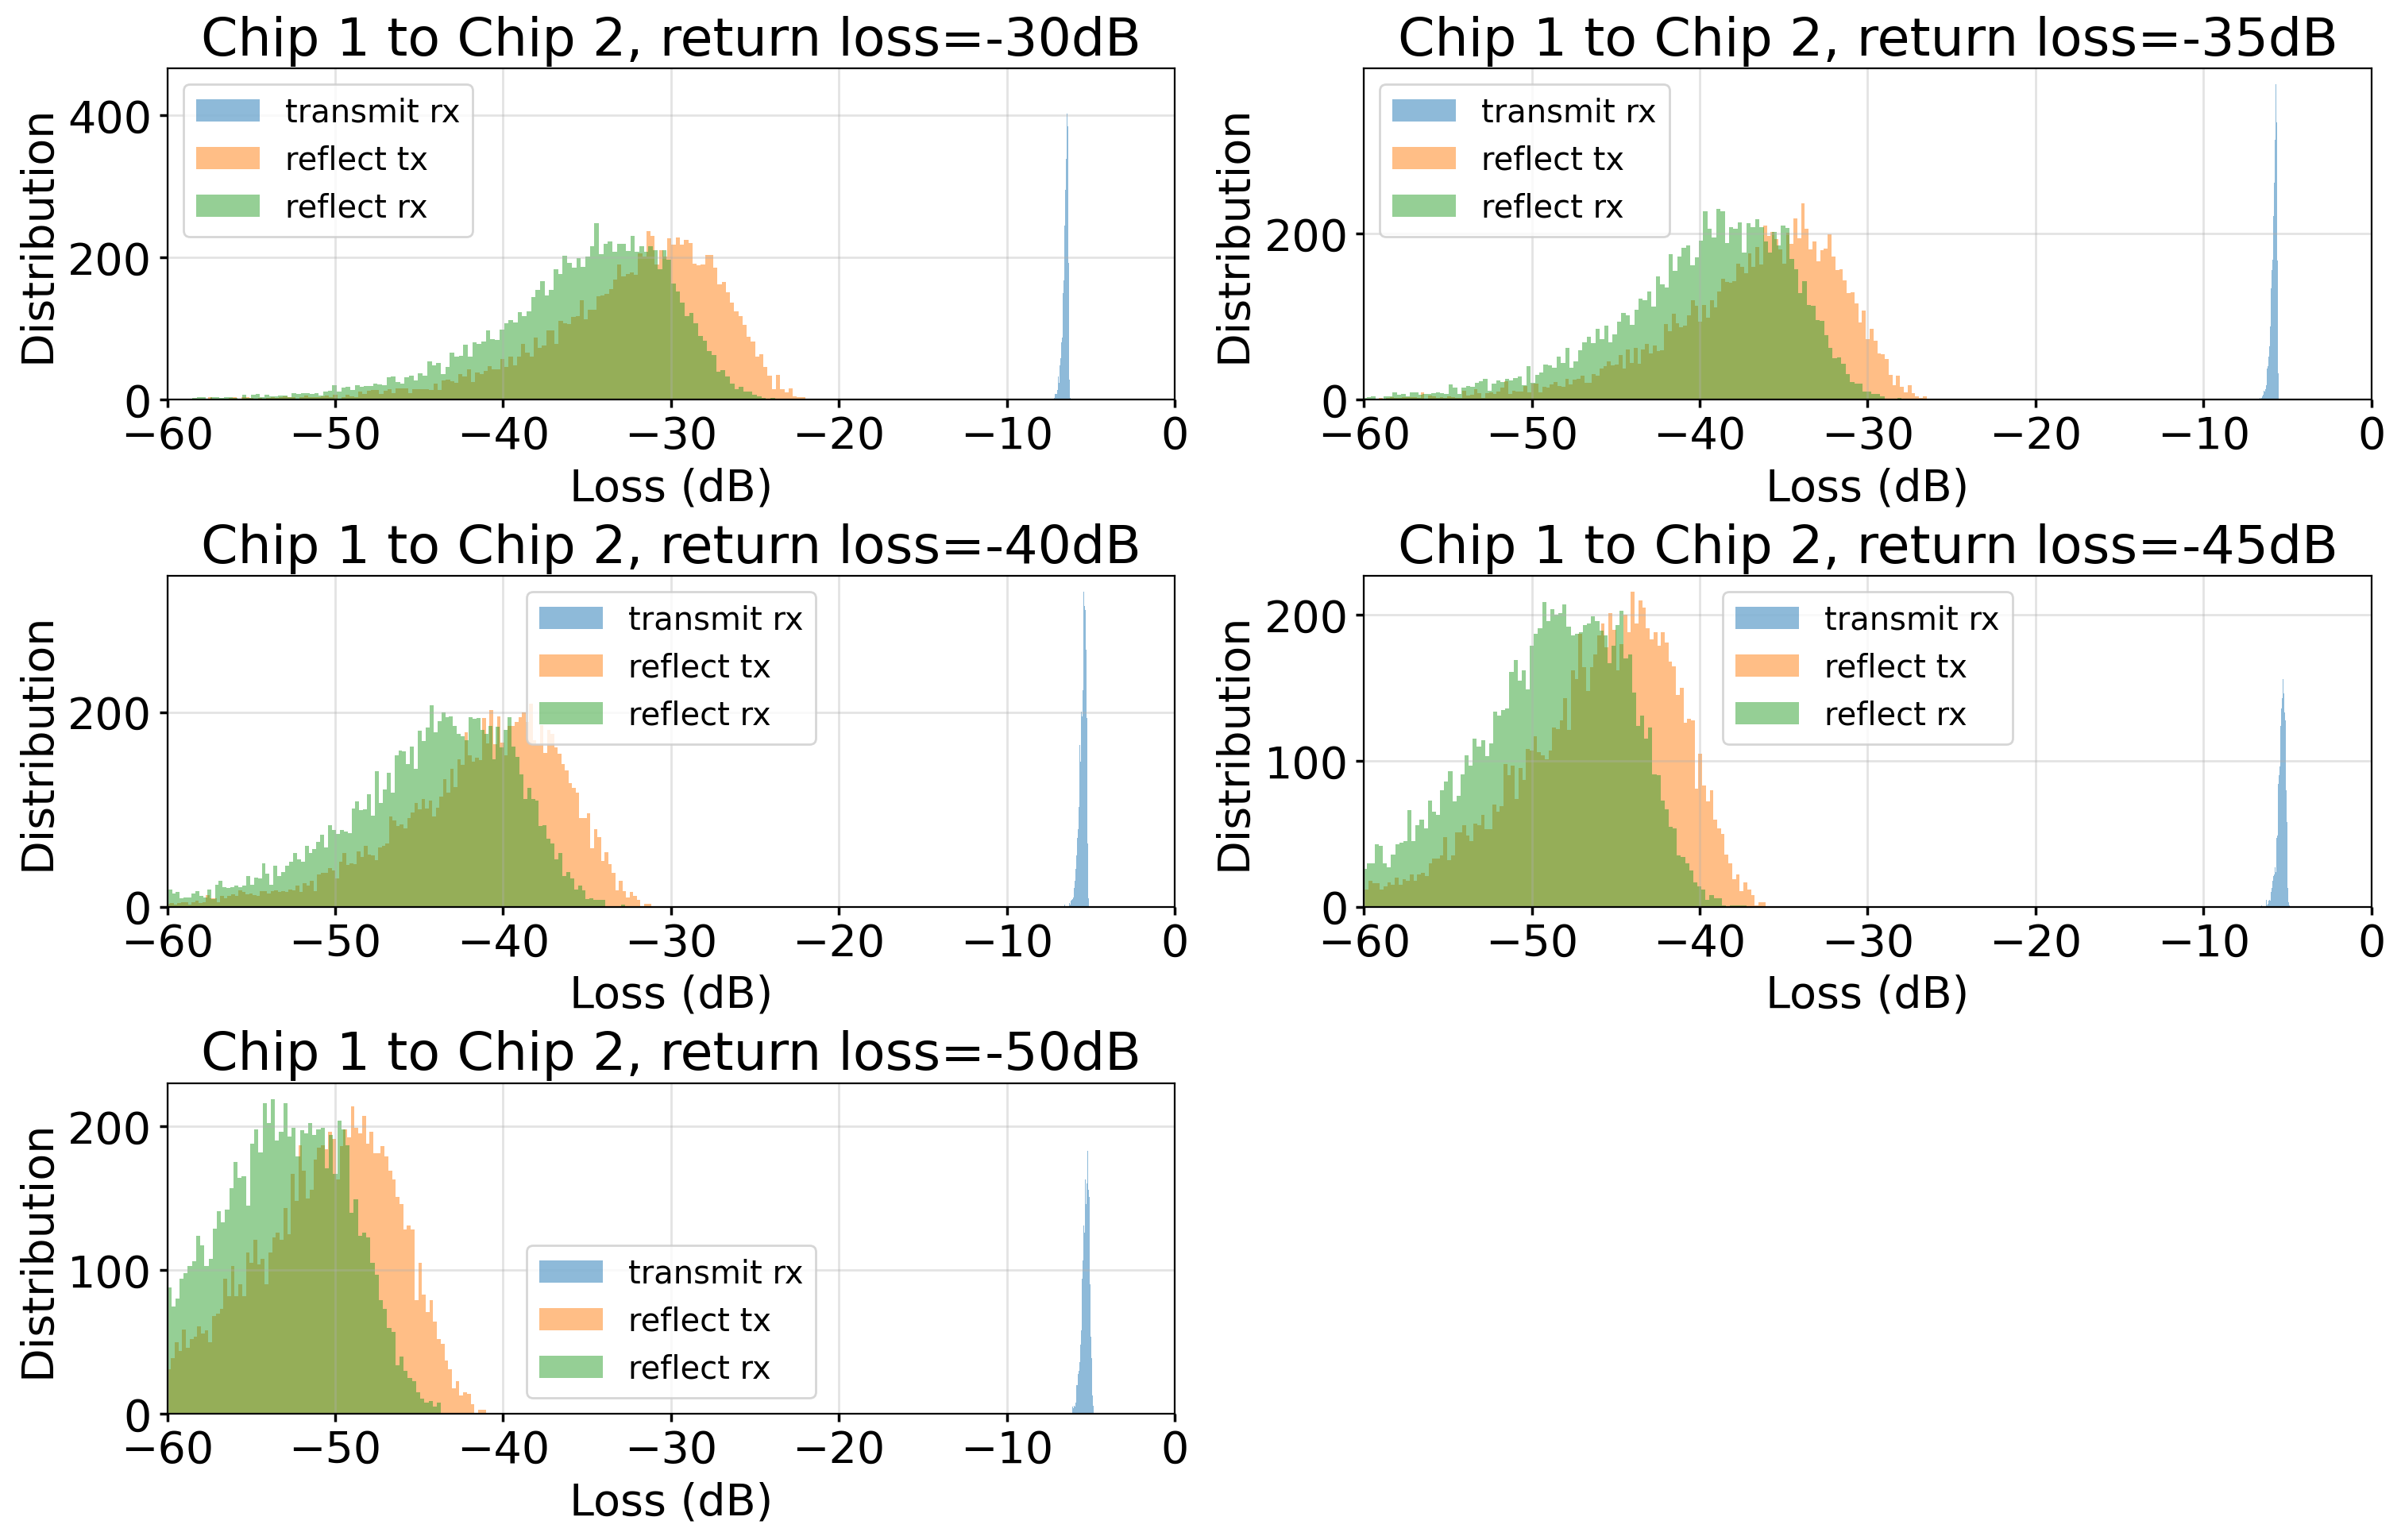

In [4]:
plt.figure(figsize=(7.5*2,10*int(len(polarization_bidi['connector_return_loss'].values)/2)))
index = 1
for return_loss in polarization_bidi['connector_return_loss'].values:
    plt.subplot(4*int(len(polarization_bidi['connector_return_loss'].values)/2), 2, index)
    mc_pol_bidi = polarization_bidi['output_state_forward_intensity'].sel(simulation_mode = 'monte_carlo', connector_return_loss = return_loss)
    plt.hist(10*np.log10(mc_pol_bidi.sel(port='forward_bottom')), bins=200, alpha=0.5, label='transmit rx')
    plt.hist(10*np.log10(mc_pol_bidi.sel(port='reverse_top')), bins=200, alpha=0.5, label='reflect tx')
    plt.hist(10*np.log10(mc_pol_bidi.sel(port='reverse_bottom')),bins=200, alpha=0.5, label='reflect rx')
    plt.xlim([-60, 0])
    plt.xlabel('Loss (dB)')
    plt.ylabel('Distribution')
    plt.title(f'Chip 1 to Chip 2, return loss={return_loss:0.0f}dB')
    plt.legend()
    index = index + 1
plt.show()

In [5]:
print(np.max(polarization_bidi['output_state_forward_intensity'].sel(simulation_mode = 'monte_carlo', connector_return_loss = polarization_bidi['connector_return_loss'].values[0],port='reverse_top').values))
print(np.max(polarization_bidi['output_state_forward_intensity'].sel(simulation_mode = 'monte_carlo', connector_return_loss = polarization_bidi['connector_return_loss'].values[0],port='reverse_bottom').values))

0.00630026454634454
0.005011166242492046


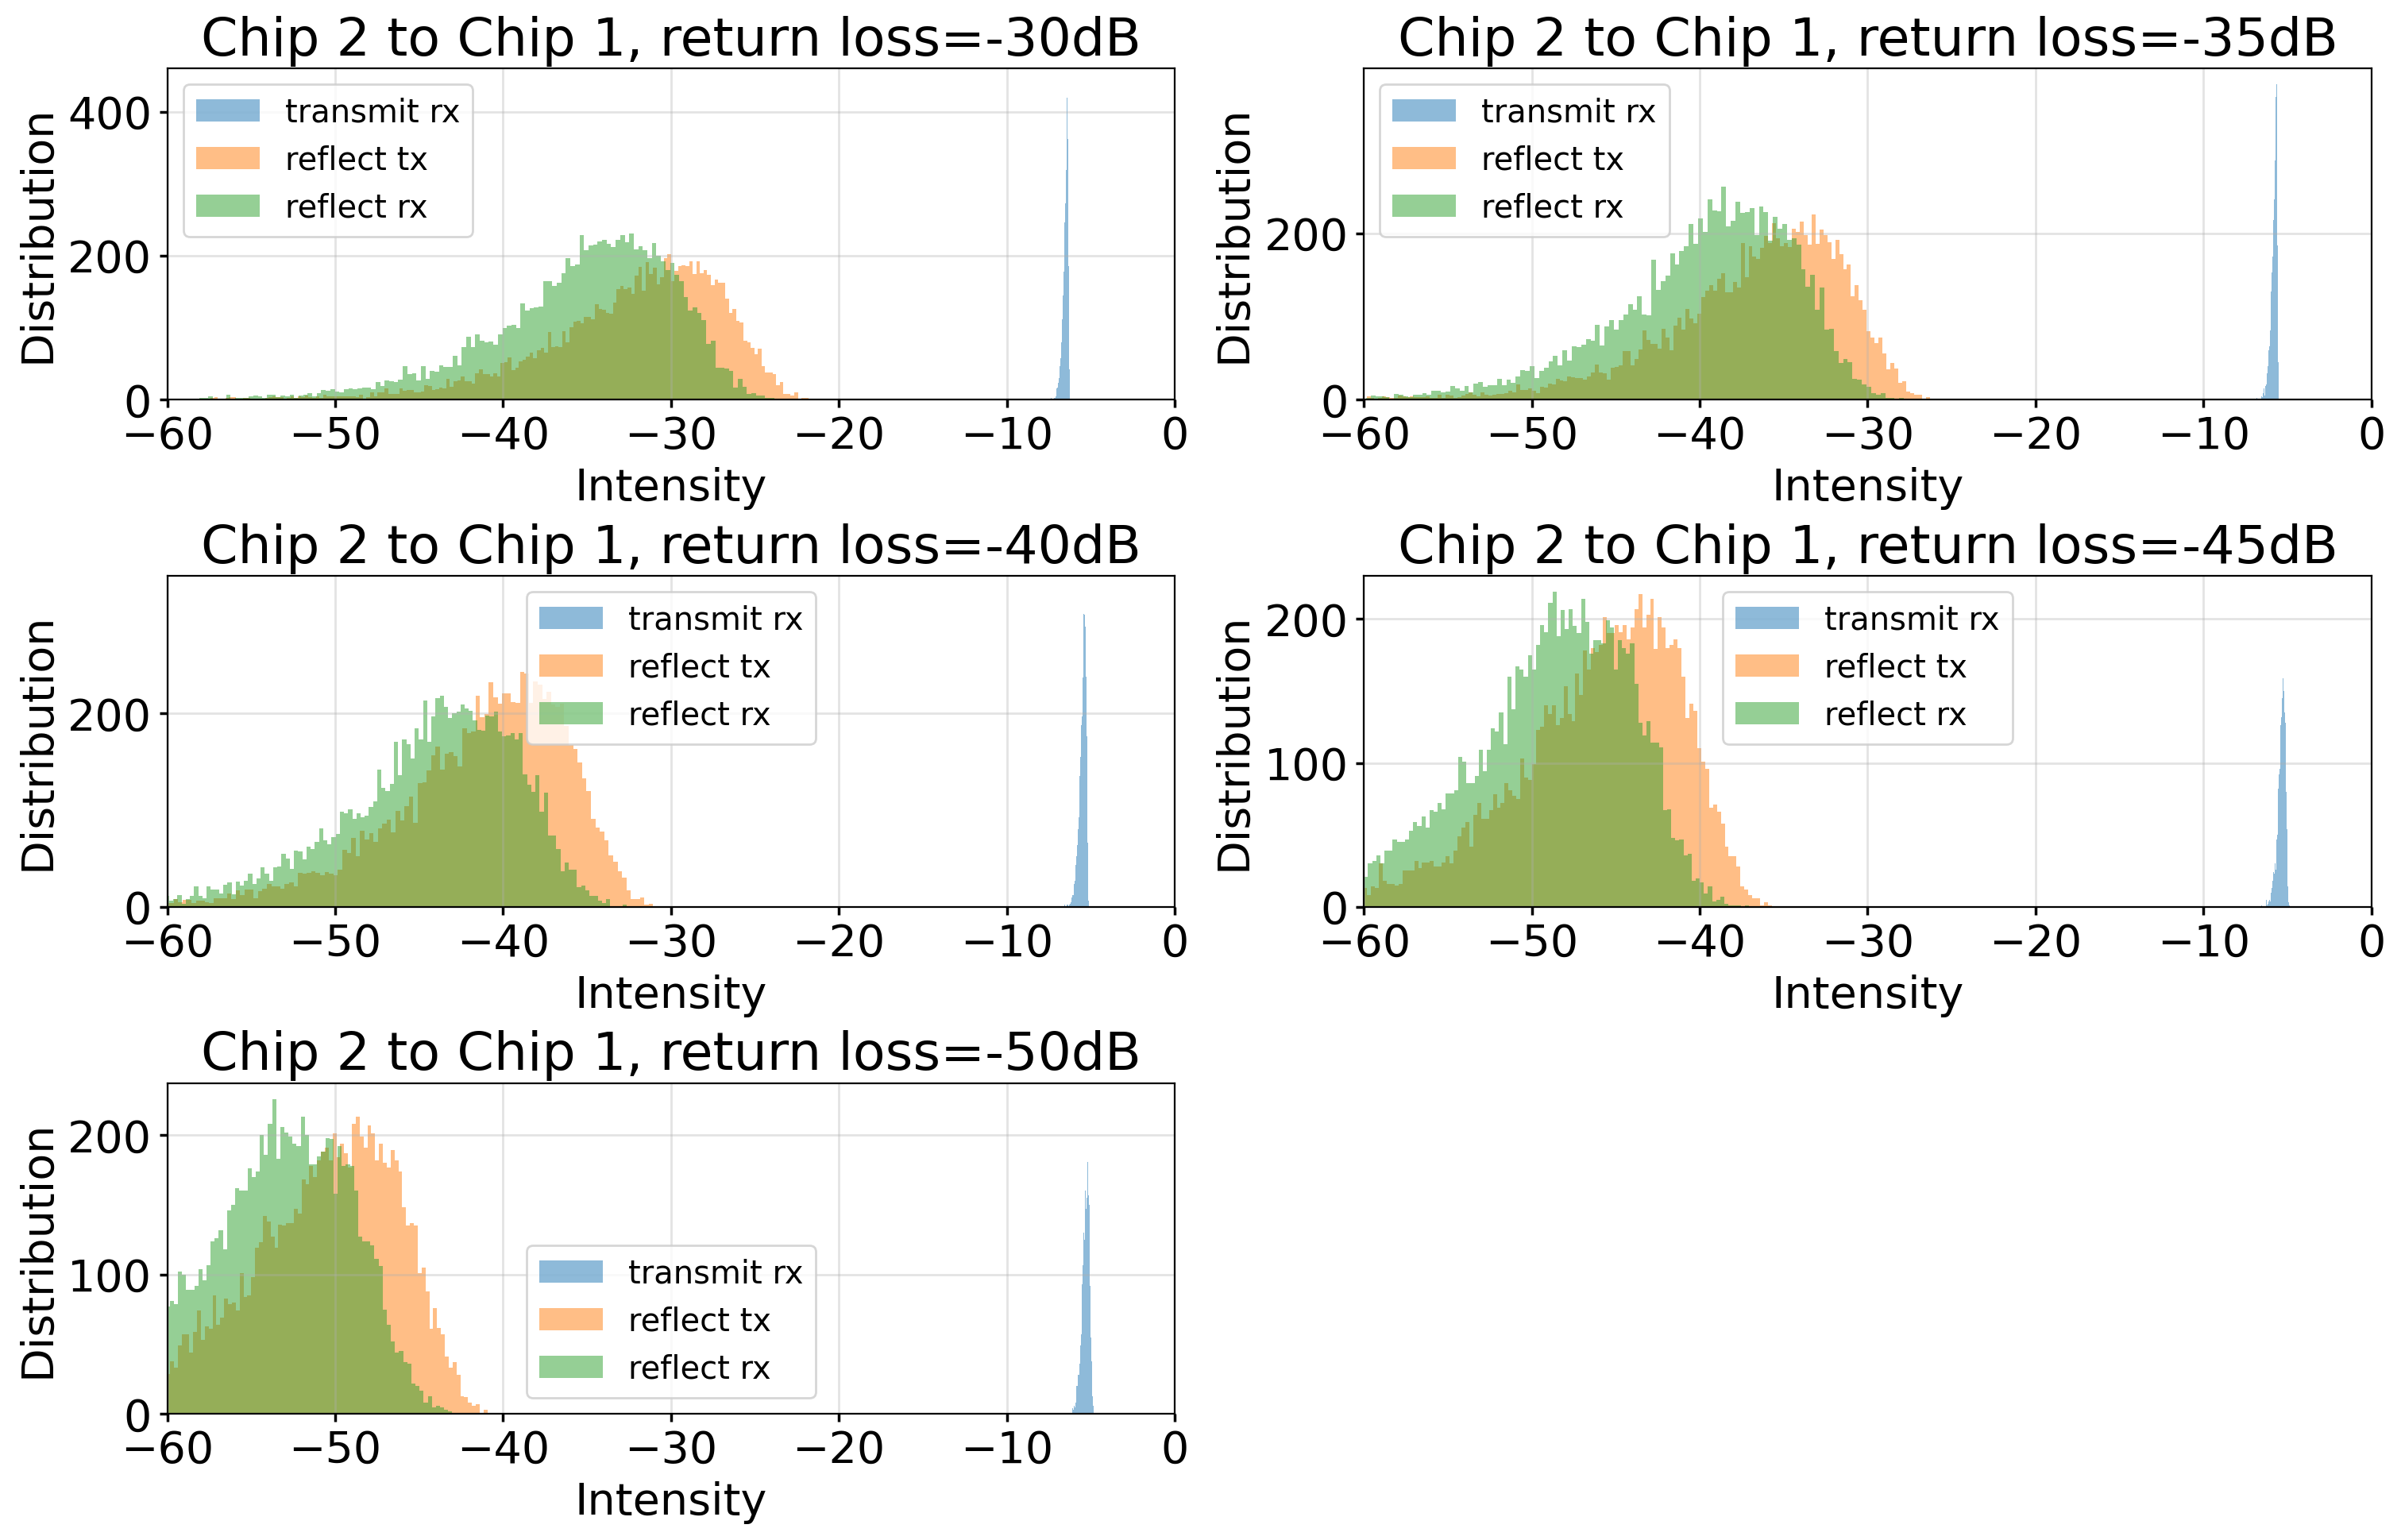

In [6]:
plt.figure(figsize=(7.5*2,10*int(len(polarization_bidi['connector_return_loss'].values)/2)))
index = 1
for return_loss in polarization_bidi['connector_return_loss'].values:
    plt.subplot(4*int(len(polarization_bidi['connector_return_loss'].values)/2), 2, index)
    mc_pol_bidi = polarization_bidi['output_state_reverse_intensity'].sel(simulation_mode = 'monte_carlo', connector_return_loss = return_loss)
    plt.hist(10*np.log10(mc_pol_bidi.sel(port='reverse_bottom')), bins=200, alpha=0.5, label='transmit rx')
    plt.hist(10*np.log10(mc_pol_bidi.sel(port='forward_top')), bins=200, alpha=0.5, label='reflect tx')
    plt.hist(10*np.log10(mc_pol_bidi.sel(port='forward_bottom')),bins=200, alpha=0.5, label='reflect rx')
    plt.xlim([-60, 0])
    plt.xlabel('Intensity')
    plt.ylabel('Distribution')
    plt.title(f'Chip 2 to Chip 1, return loss={return_loss:0.0f}dB')
    plt.legend()
    index = index + 1
plt.show()

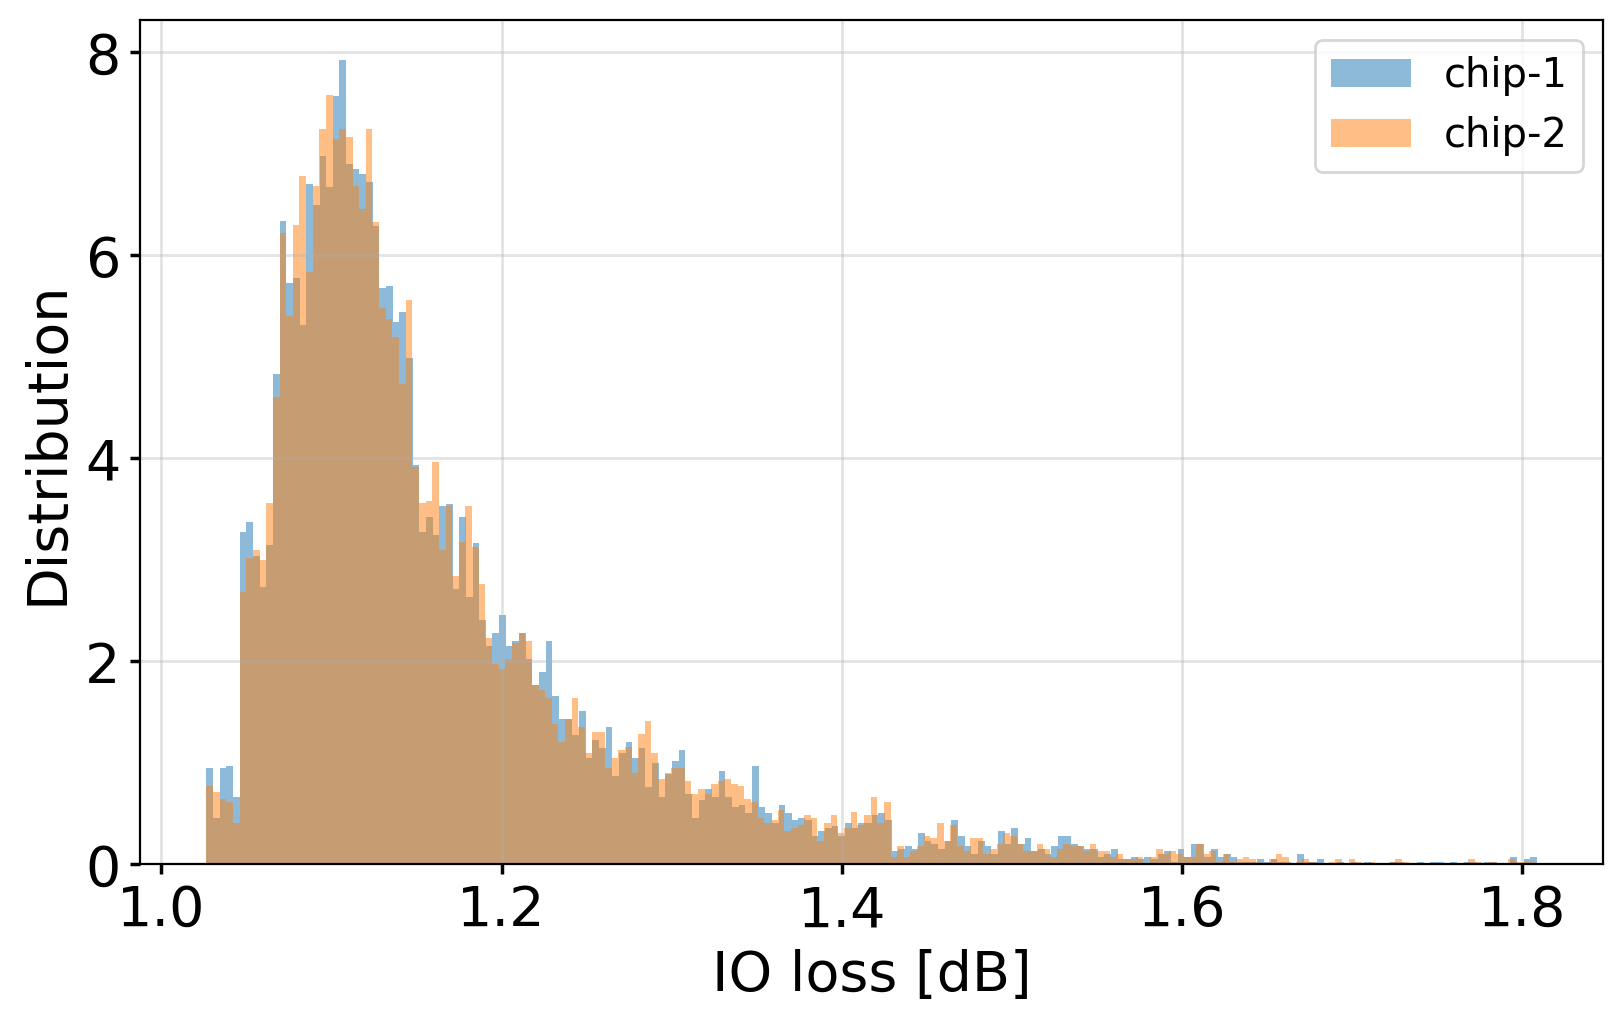

In [7]:
for chip in polarization_bidi['chip'].values:
  mc_pol_bidi = polarization_bidi['io_loss'].sel(chip = chip, simulation_mode = 'monte_carlo', connector_return_loss = polarization_bidi['connector_return_loss'].values[0])
  plt.hist(mc_pol_bidi.values, bins=200, density=True, alpha=0.5, label=chip)
plt.xlabel('IO loss [dB]')
plt.ylabel('Distribution')
plt.legend()

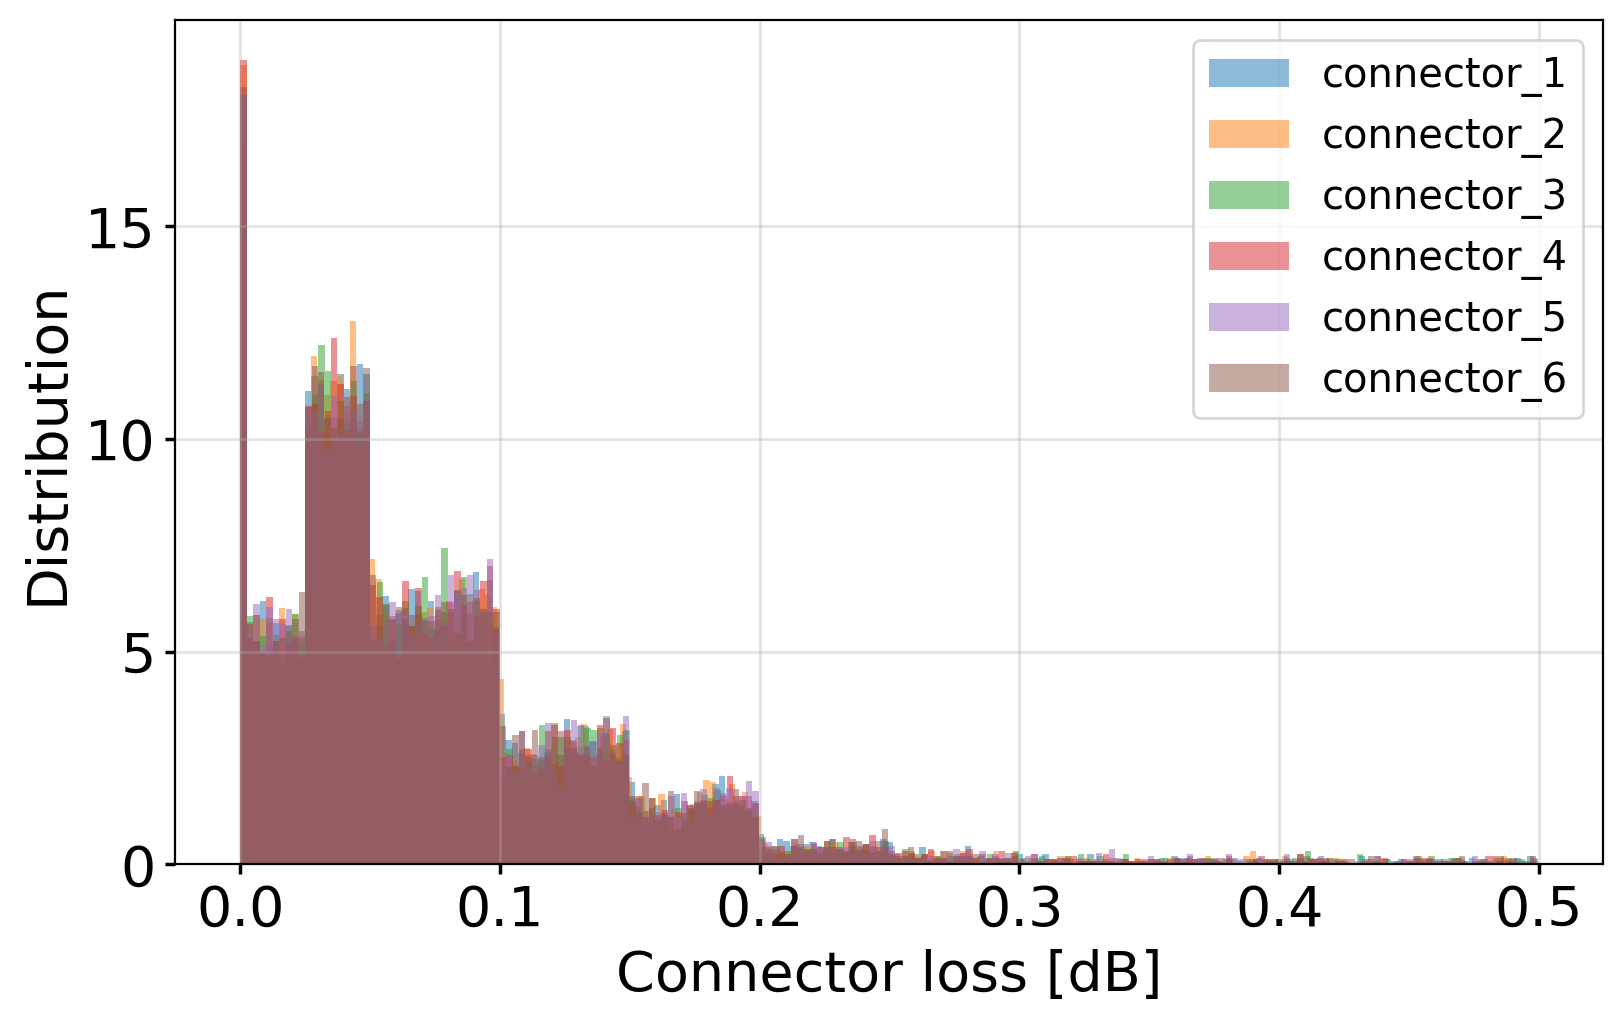

In [8]:
for connector in polarization_bidi['connector_num'].values:
  mc_pol_bidi = polarization_bidi['connector_loss'].sel(connector_num = connector, simulation_mode = 'monte_carlo', connector_return_loss = polarization_bidi['connector_return_loss'].values[0])
  plt.hist(mc_pol_bidi.values, bins=200, density=True, alpha=0.5, label=connector)
plt.xlabel('Connector loss [dB]')
plt.ylabel('Distribution')
plt.legend()

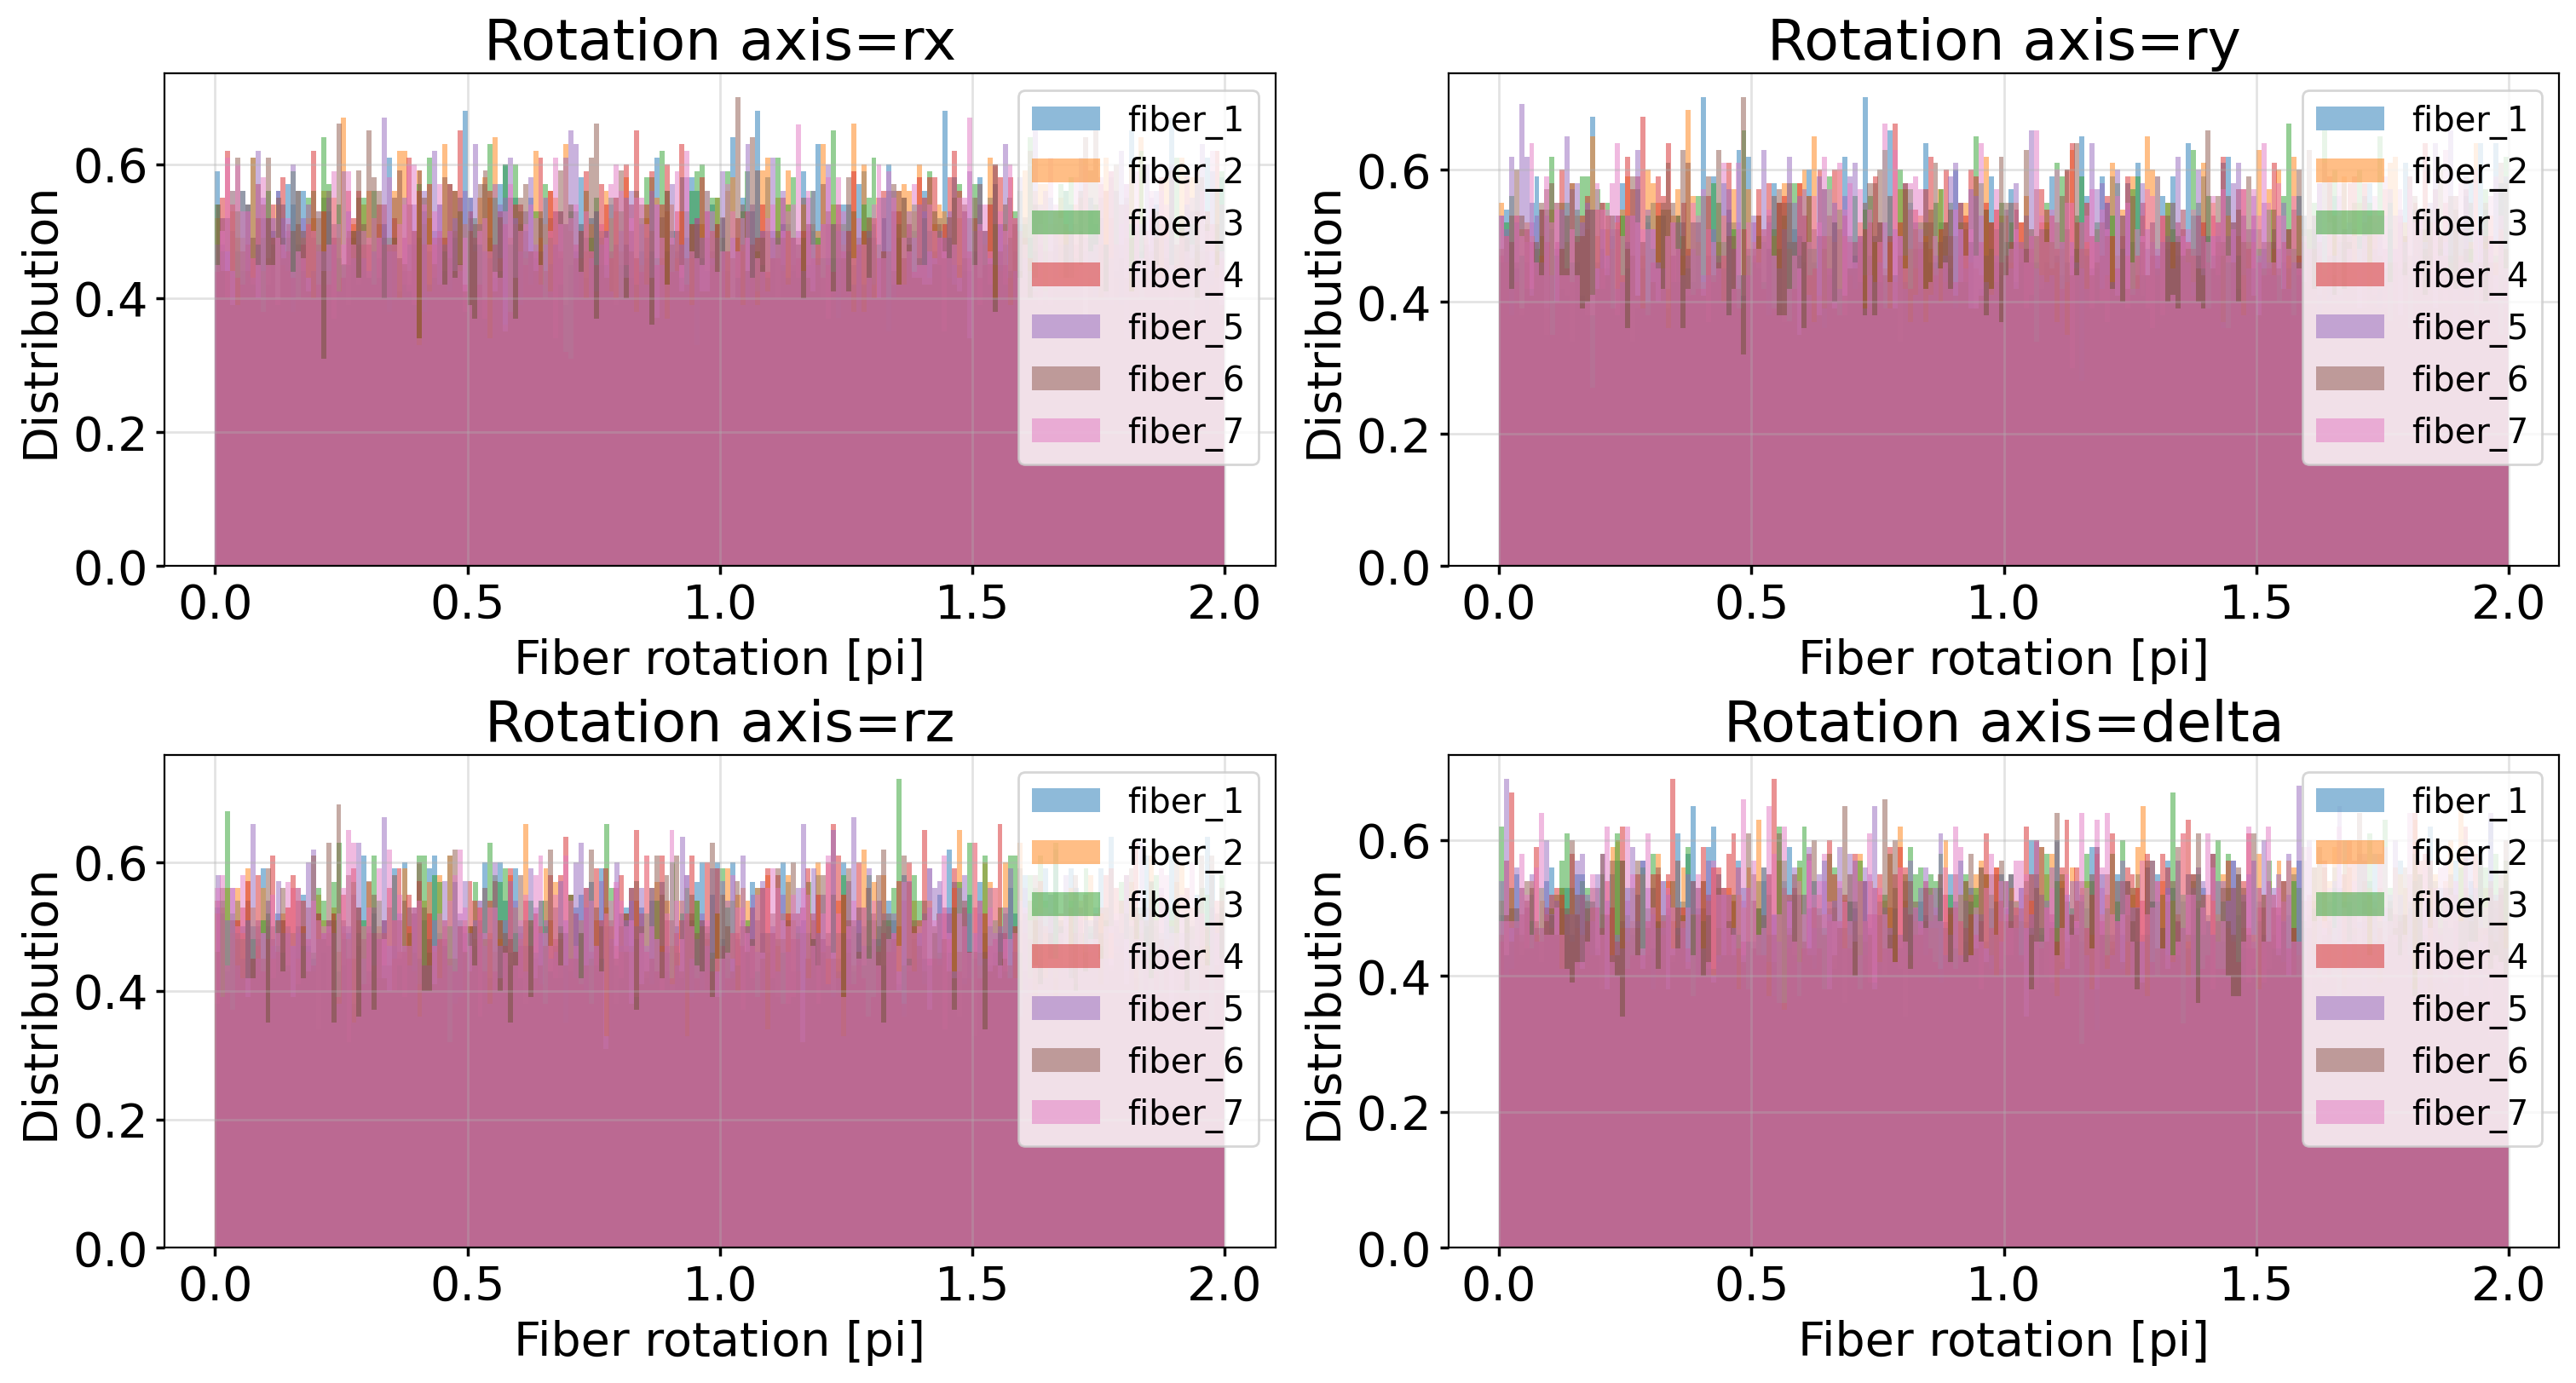

In [9]:
plt.figure(figsize=(15,8))
for idd_axis, axis in enumerate(polarization_bidi['axis'].values):
  plt.subplot(2,2,idd_axis+1)
  for fiber in polarization_bidi['fiber_num'].values:
    mc_pol_bidi = polarization_bidi['fiber_rotation'].sel(axis = axis, fiber_num = fiber, simulation_mode = 'monte_carlo', connector_return_loss = polarization_bidi['connector_return_loss'].values[0])
    plt.hist(mc_pol_bidi.values/np.pi, bins=200, density=True, alpha=0.5, label=fiber)
  plt.xlabel('Fiber rotation [pi]')
  plt.ylabel('Distribution')
  plt.title("Rotation axis=" + axis)
  plt.legend()